### Part 1: IMPORT LIBRARIES ###

In [1]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import seaborn as sns

sns.set(rc={'figure.figsize': (10, 6)})
sns.set_style('whitegrid')
sns.set_palette('Set2')

In [2]:
# change this path according to the location where you store your data
path = './data'
full_path_list = [ path + '/' + f for \
                 f in os.listdir(path) if os.path.isfile(os.path.join(path,f)) ]

### PART 2: LOAD DATA ###

In [3]:
# The fitbit dataset is inclusive of hours and minutes datasets as well. However, for the purpose of this exercise, 
# it is chosen to analyze daily aggregated data only.

# connect to sql db
con = sql.connect("fitbit.db")
cur = con.cursor()

def get_table_name(full_path_list, i):
    return full_path_list[i].split("/")[-1].split('.')[0]

pbar = tqdm(total=len(full_path_list), desc='[Loading Data...]')
for i in range(0,len(full_path_list)):
    pd.read_csv(full_path_list[i]).to_sql(get_table_name(full_path_list, i), con, if_exists='append', index=False)
    pbar.update(1)
pbar.close()

[Loading Data...]: 100%|█████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 20.81it/s]


In [4]:
# simple query test
df = pd.read_sql(f'SELECT * FROM {get_table_name(full_path_list, 0)}', con)

df.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [5]:
# list all tables
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()
print(f'Total of {len(tables)} tables in database.')


Total of 6 tables in database.


### Part 3: PREPARE DATA ###

In [6]:
# check for sample data and data size...
dailyActivity_df = pd.read_sql(f'SELECT * FROM dailyActivity_merged', con)

print(len(dailyActivity_df))

dailyActivity_df.head()

940


,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [7]:
# update date to match sqlite format
update_date = """
UPDATE dailyActivity_merged set ActivityDate =
	SUBSTR(ActivityDate, -4)
	|| "-" ||
	CASE
		WHEN LENGTH(
			SUBSTR( -- picking month info
				ActivityDate, 1, INSTR(ActivityDate, '/') - 1
			)
		) > 1 THEN
			SUBSTR( -- picking month info
				ActivityDate, 1, INSTR(ActivityDate, '/') - 1
			)
		ELSE '0' ||
			SUBSTR( -- picking month info
				ActivityDate, 1, INSTR(ActivityDate, '/') - 1
			)
	END
	|| "-" ||
	CASE
	WHEN LENGTH(
		SUBSTR( -- picking day info
			SUBSTR(ActivityDate, INSTR(ActivityDate, '/') + 1), -- pick substring starting after first /
			1,  -- start new substring at first character of newly selected substring
			INSTR(SUBSTR(ActivityDate, INSTR(ActivityDate, '/') + 1), '/') - 1 -- go all the way to next /
		)
	) > 1 THEN
		SUBSTR( -- picking day info
			SUBSTR(ActivityDate, INSTR(ActivityDate, '/') + 1), -- pick substring starting after first /
			1,  -- start new substring at first character of newly selected substring
			INSTR(SUBSTR(ActivityDate, INSTR(ActivityDate, '/') + 1), '/') - 1 -- go all the way to next /
		)
	ELSE '0' ||
		SUBSTR( -- picking day info
			SUBSTR(ActivityDate, INSTR(ActivityDate, '/') + 1), -- pick substring starting after first /
			1,  -- start new substring at first character of newly selected substring
			INSTR(SUBSTR(ActivityDate, INSTR(ActivityDate, '/') + 1), '/') - 1 -- go all the way to next /
		)
	END;
"""
cur.execute(update_date)
con.commit()
con.close()

In [8]:
# Connect again to sql db
con = sql.connect("fitbit.db")
cur = con.cursor()

# query sleep data
sleep_query = """
SELECT
	*
FROM
	sleepDay_merged;
"""

sleep_df = pd.read_sql(sleep_query, con)

sleep_df.head()

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
0,1503960366,4/12/2016 12:00:00 AM,1,327,346
1,1503960366,4/13/2016 12:00:00 AM,2,384,407
2,1503960366,4/15/2016 12:00:00 AM,1,412,442
3,1503960366,4/16/2016 12:00:00 AM,2,340,367
4,1503960366,4/17/2016 12:00:00 AM,1,700,712


In [9]:
#update data to match sql lite format
update_date = """
UPDATE sleepDay_merged set SleepDay =
	SUBSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), -4)
	|| "-" ||
	CASE
		WHEN LENGTH(
			SUBSTR( -- picking month info
				SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), 1, INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') - 1
			)
		) > 1 THEN
			SUBSTR( -- picking month info
				SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), 1, INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') - 1
			)
		ELSE '0' ||
			SUBSTR( -- picking month info
				SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), 1, INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') - 1
			)
	END
	|| "-" ||
	CASE
	WHEN LENGTH(
		SUBSTR( -- picking day info
			SUBSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') + 1), -- pick substring starting after first /
			1,  -- start new substring at first character of newly selected substring
			INSTR(SUBSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') + 1), '/') - 1 -- go all the way to next /
		)
	) > 1 THEN
		SUBSTR( -- picking day info
			SUBSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') + 1), -- pick substring starting after first /
			1,  -- start new substring at first character of newly selected substring
			INSTR(SUBSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') + 1), '/') - 1 -- go all the way to next /
		)
	ELSE '0' ||
		SUBSTR( -- picking day info
			SUBSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') + 1), -- pick substring starting after first /
			1,  -- start new substring at first character of newly selected substring
			INSTR(SUBSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') + 1), '/') - 1 -- go all the way to next /
		)
	END;
"""
cur.execute(update_date)
con.commit()
con.close()


In [10]:
# check if the updates are correct
con = sql.connect("fitbit.db")
cur = con.cursor()

sleep_query = """
SELECT *,
	STRFTIME('%w',SleepDay) dow
FROM sleepDay_merged;
"""

sleep_df = pd.read_sql(sleep_query, con)

sleep_df.head()


,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,dow
0,1503960366,2016-04-12,1,327,346,2
1,1503960366,2016-04-13,2,384,407,3
2,1503960366,2016-04-15,1,412,442,5
3,1503960366,2016-04-16,2,340,367,6
4,1503960366,2016-04-17,1,700,712,0


In [11]:
# extract day,month,year
full_info_activity = """
SELECT *,
	STRFTIME('%d',ActivityDate) day,
	STRFTIME('%m',ActivityDate) month,
	STRFTIME('%Y',ActivityDate) year,
	STRFTIME('%w',ActivityDate) dow
FROM dailyActivity_merged;
"""

full_dailyActivity_df = pd.read_sql(full_info_activity, con)

### PART 4: EXPLORATORY DATA ANALYSIS ###

In [12]:
# Count how many users we have data for
cur.execute("SELECT COUNT(DISTINCT Id) FROM dailyActivity_merged;")
print('Different users: ', cur.fetchall()[0][0])

Different users:  33


In [13]:
# Average Calories, Steps and Distance by Id and by day of the week
query = """
SELECT
	Id,
	STRFTIME('%w', ActivityDate) dow,
	ROUND(AVG(Calories),2) AS avg_calories,
	ROUND(AVG(TotalSteps),2) AS avg_steps,
	ROUND(AVG(TotalDistance),2) AS avg_distance
FROM dailyActivity_merged
GROUP BY Id, STRFTIME('%w', ActivityDate);
"""

activity_dist = pd.read_sql(query, con)
activity_dist.head()

,Id,dow,avg_calories,avg_steps,avg_distance
0,1503960366,0,1769.00,10101.50,6.57
1,1503960366,1,1939.25,13780.75,8.96
2,1503960366,2,1967.80,13946.60,8.92
3,1503960366,3,1868.80,12656.60,8.23
4,1503960366,4,1481.60,9500.60,6.10


In [14]:
# "Boolean" column to check if date corresponds to weekend
weekend_query = """
SELECT
	Id,
	ActivityDate,
	SedentaryMinutes,
	VeryActiveMinutes,
	FairlyActiveMinutes,
	LightlyActiveMinutes,
	Calories,
	TotalSteps,
	TotalDistance,
	CASE
		WHEN STRFTIME('%w',ActivityDate) IN ('0','6')
			THEN 1
		ELSE 0
	END weekend
FROM dailyActivity_merged;
"""

weekend_check = pd.read_sql(weekend_query, con)

weekend_check.head()

,Id,ActivityDate,SedentaryMinutes,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,Calories,TotalSteps,TotalDistance,weekend
0,1503960366,2016-04-12,728,25,13,328,1985,13162,8.50,0
1,1503960366,2016-04-13,776,21,19,217,1797,10735,6.97,0
2,1503960366,2016-04-14,1218,30,11,181,1776,10460,6.74,0
3,1503960366,2016-04-15,726,29,34,209,1745,9762,6.28,0
4,1503960366,2016-04-16,773,36,10,221,1863,12669,8.16,1


In [15]:
# join daily activity data and sleep data
join_query = """
SELECT
	A.Id,
	A.ActivityDate,
	A.SedentaryMinutes,
	A.LightlyActiveMinutes,
	S.TotalMinutesAsleep
FROM
	dailyActivity_merged A
INNER JOIN sleepDay_merged S
ON
	A.Id = S.Id AND
    A.ActivityDate = S.SleepDay;
"""
activity_sleep_df = pd.read_sql(join_query, con)

activity_sleep_df.head()

,Id,ActivityDate,SedentaryMinutes,LightlyActiveMinutes,TotalMinutesAsleep
0,1503960366,2016-04-12,728,328,327
1,1503960366,2016-04-13,776,217,384
2,1503960366,2016-04-15,726,209,412
3,1503960366,2016-04-16,773,221,340
4,1503960366,2016-04-17,539,164,700


<AxesSubplot:xlabel='SedentaryMinutes', ylabel='SedentaryActiveDistance'>

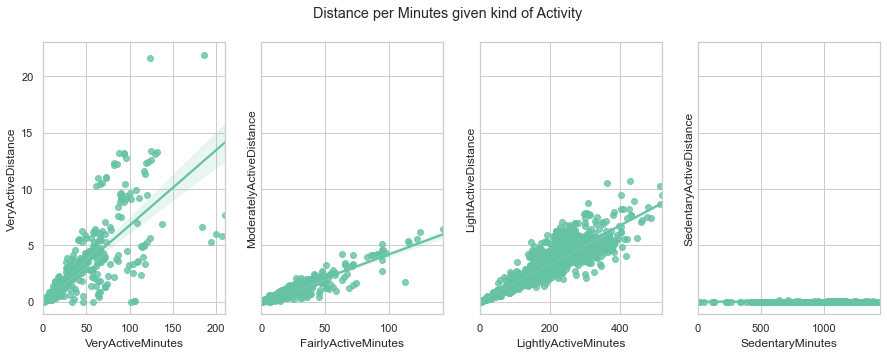

In [16]:
# Initial Exploratory Visualizations
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
fig.suptitle('Distance per Minutes given kind of Activity')

sns.regplot(data = dailyActivity_df, x = 'VeryActiveMinutes', y = 'VeryActiveDistance', ax=axes[0])

sns.regplot(data = dailyActivity_df, x = 'FairlyActiveMinutes', y = 'ModeratelyActiveDistance', ax=axes[1])

sns.regplot(data = dailyActivity_df, x = 'LightlyActiveMinutes', y = 'LightActiveDistance', ax=axes[2])

sns.regplot(data = dailyActivity_df, x = 'SedentaryMinutes', y = 'SedentaryActiveDistance', ax=axes[3])

As expected, the VeryActive distances are traveled in shorter times (that is, they have larger speeds represented by steeper regression lines). A somewhat unexpected result here is that LightlyActiveMinutes lead to greater speeds than FairlyActiveMinutes. It would be interesting to know how this classification is done to actually understand the difference between "Light" activities and "Moderate" activities.

intercept: 1665.7426768758332
slope: [0.08351327]


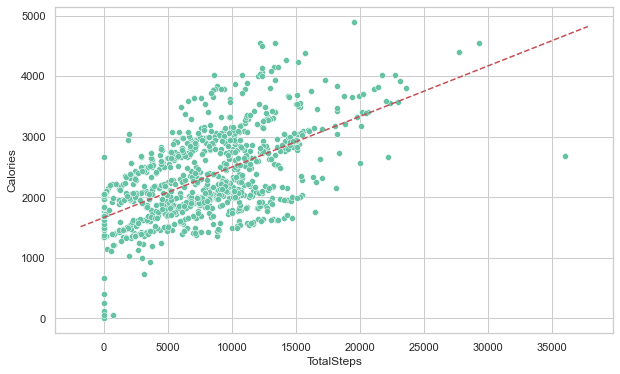

In [17]:
# fit a regression line to totalsteps and calories
import numpy as np
from sklearn.linear_model import LinearRegression

X = full_dailyActivity_df['TotalSteps'].values.reshape((-1, 1))
y = full_dailyActivity_df['Calories'].values

model = LinearRegression()
model.fit(X, y)

print('intercept:', model.intercept_)
print('slope:', model.coef_)

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, color= 'r', ls = '--')
    
sns.scatterplot(data = full_dailyActivity_df, x= 'TotalSteps', y ='Calories')
abline(model.coef_, model.intercept_);

Once more, as expected the amount of calories burned in a day grows as the user takes more steps. An intersting fact is that the intercept of the regression line represents the amount of burned calories in a day with no steps taken. This is the amount of calories users are burning in a very sedentary day. According to the Healthline site, this number corresponds to the basal metabolic rate. 

This value can be calculated (again referring to Healthline) if we know the user's sex, weight, height and age. 

For example, they report that a 35-year-old man who weighs 175 pounds and is 5 feet 11 inches would have a BMR of 1,816 calories and a 35-year-old woman who weighs 135 pounds and is 5 feet, 5 inches would have a BMR of 1,383 calories.

To compare these estimates with our data, we can get the intercept value using Linear Regression

The predicted BMR is ~1665.74 (between those predicted for the 35-year-old woman and man). 

We can further get information on the BMR of our users if we filter only the data points with zero steps taken and get the statistics on the Calories distribution. 

In [18]:
full_dailyActivity_df[full_dailyActivity_df['TotalSteps']==0]['Calories'].describe()

count      77.000000
mean     1657.077922
std       557.082290
min         0.000000
25%      1496.000000
50%      1841.000000
75%      1980.000000
max      2664.000000
Name: Calories, dtype: float64

In [19]:
full_dailyActivity_df[full_dailyActivity_df['Calories']==0]

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,day,month,year,dow
30,1503960366,2016-05-12,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0,12,05,2016,4
653,6290855005,2016-05-10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0,10,05,2016,2
817,8253242879,2016-04-30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0,30,04,2016,6
879,8583815059,2016-05-12,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0,12,05,2016,4


There are many rows with all zero values except for the SedentaryMinutes column. In this column we see that users spent 1440 minutes of sedentary activity in a single day. 

That's the whole day: 
1440minutes divided by 60minutes/hour = 24h. 

So, it seems either the tracker may have been turned off the entire day or there may be some malfunction. We should get rid of these data points in further analysis.

In [20]:
# query full_info_activity
full_info_activity = """
SELECT *,
	STRFTIME('%d',ActivityDate) day,
	STRFTIME('%m',ActivityDate) month,
	STRFTIME('%Y',ActivityDate) year,
	STRFTIME('%w',ActivityDate) dow
FROM 
	dailyActivity_merged
WHERE
	Calories <> 0;
"""

full_dailyActivity_df = pd.read_sql(full_info_activity, con)

len(full_dailyActivity_df)

936

The dataset contains only 4 rows of non-usable data

intercept: 1689.151000014402
slope: [0.08138959]


(1689.151000014402, array([0.08138959]))

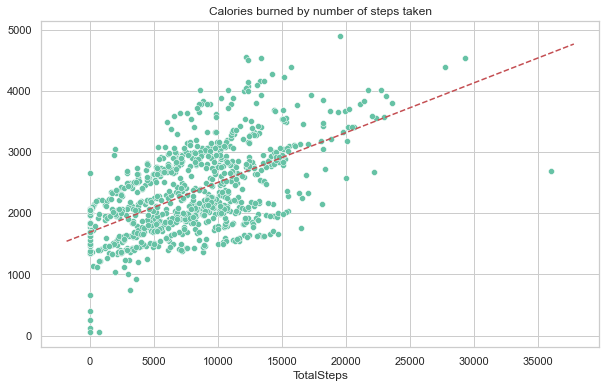

In [21]:
# fit a line for full daily activity and get intercept and slope 
def get_regression(full_dailyActivity_df, x ='TotalSteps', y = 'Calories'):
    X = full_dailyActivity_df[x].values.reshape((-1, 1))
    y = full_dailyActivity_df[y].values

    model = LinearRegression()
    model.fit(X, y)

    print('intercept:', model.intercept_)
    print('slope:', model.coef_)

    sns.scatterplot(data = full_dailyActivity_df, x= x, y =y)
    plt.title('Calories burned by number of steps taken')
    abline(model.coef_, model.intercept_);

    return (model.intercept_, model.coef_)

get_regression(full_dailyActivity_df)

Let's look at the data distribution for VeryActiveMinutes, FairlyActiveMinutes and LightlyActiveMinutes

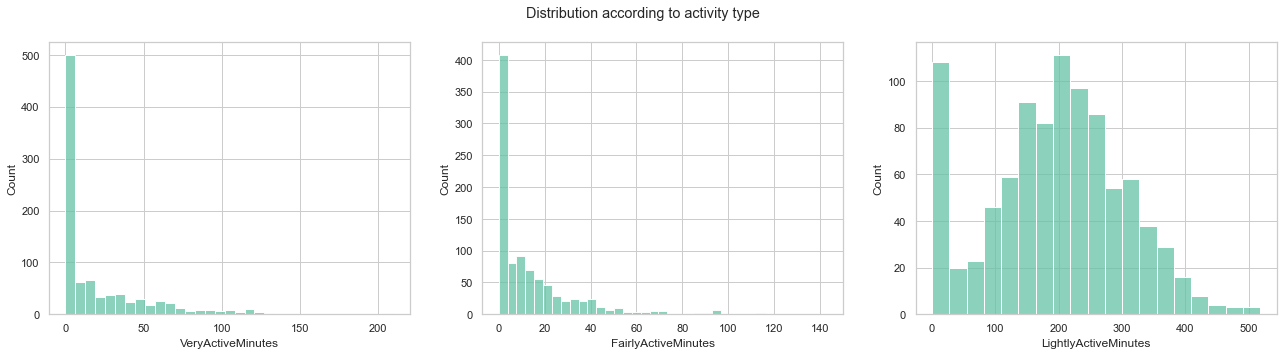

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(22, 5))
fig.suptitle('Distribution according to activity type')

sns.histplot(data = full_dailyActivity_df, x = 'VeryActiveMinutes', ax = axes[0]);

sns.histplot(data = full_dailyActivity_df, x = 'FairlyActiveMinutes', ax = axes[1]);

sns.histplot(data = full_dailyActivity_df, x = 'LightlyActiveMinutes', ax = axes[2]);

There is an issue here: it is not clear if all users were using the tracker during the entire day in the analysed period. If a user logs the whole day, then the sum VeryActiveMinutes + FairlyActiveMinutes + LightlyActiveMinutes + SedentaryMinutes should be equal to 1440 minutes (the total number of minutes in a day).

In [23]:
full_day_activity = """
SELECT *,
	STRFTIME('%d',ActivityDate) day,
	STRFTIME('%m',ActivityDate) month,
	STRFTIME('%Y',ActivityDate) year,
	STRFTIME('%w',ActivityDate) dow,
	VeryActiveMinutes+FairlyActiveMinutes+LightlyActiveMinutes+SedentaryMinutes AS TotalMinutes
FROM 
	dailyActivity_merged
WHERE
	Calories <> 0 AND
	TotalMinutes = 1440;
"""

logged_day_df = pd.read_sql(full_day_activity, con)

print(f'There are {len(logged_day_df)} (out of {len(full_dailyActivity_df)}) rows where users logged the whole day.')

There are 474 (out of 936) rows where users logged the whole day.


In [24]:
not_full_day = """
SELECT *,
	STRFTIME('%d',ActivityDate) day,
	STRFTIME('%m',ActivityDate) month,
	STRFTIME('%Y',ActivityDate) year,
	STRFTIME('%w',ActivityDate) dow,
	VeryActiveMinutes+FairlyActiveMinutes+LightlyActiveMinutes+SedentaryMinutes AS TotalMinutes
FROM 
	dailyActivity_merged
WHERE
	Calories <> 0 AND
	TotalMinutes <> 1440;
"""

not_logged_day_df = pd.read_sql(not_full_day, con)

print(f'There are {len(not_logged_day_df)} rows where users logged parts of the day.')


There are 462 rows where users logged parts of the day.


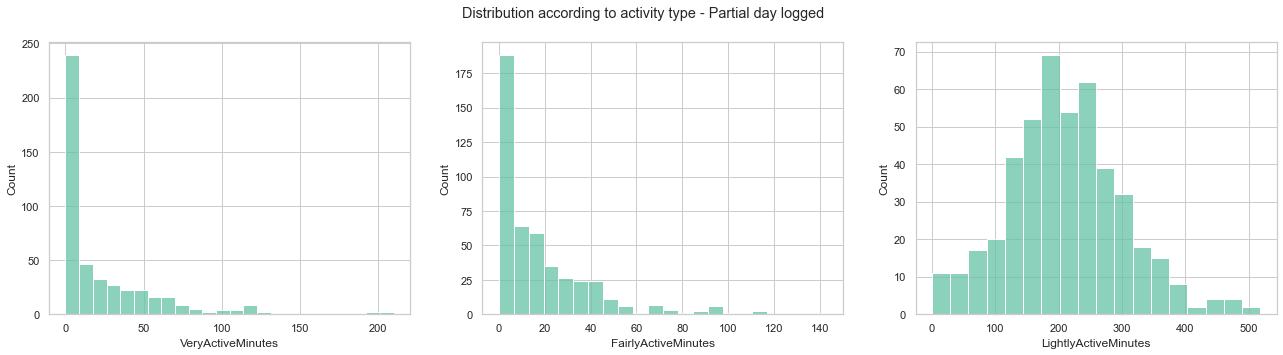

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(22, 5))
fig.suptitle('Distribution according to activity type - Partial day logged')

sns.histplot(data = not_logged_day_df, x = 'VeryActiveMinutes', ax = axes[0]);

sns.histplot(data = not_logged_day_df, x = 'FairlyActiveMinutes', ax = axes[1]);

sns.histplot(data = not_logged_day_df, x = 'LightlyActiveMinutes', ax = axes[2]);

The LightlyActiveMinutes distribution is very symmetric with no peak at very few minutes of activity. Users who log the entire day may end up registering a lot of LightlyActiveMinutes while those who log only a part of the day might be registering only activities with higher demand.

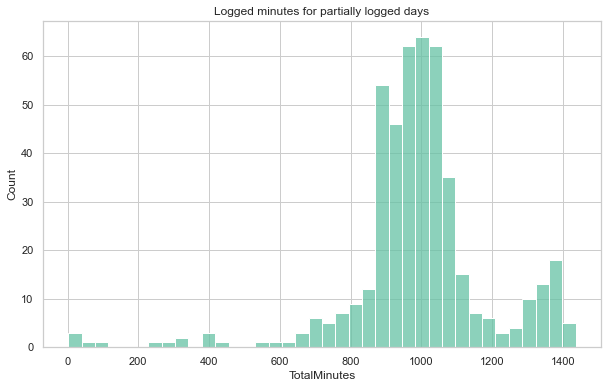

In [26]:
sns.histplot(data = not_logged_day_df, x = 'TotalMinutes')
plt.title('Logged minutes for partially logged days');

Let's take a look at the Sleeping Habits

Text(380, 30, '7h of sleep')

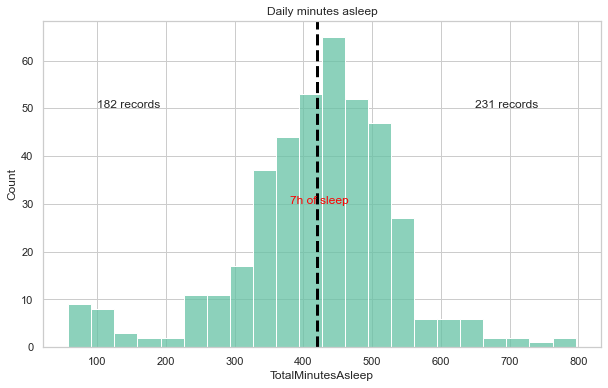

In [27]:
sns.histplot(data = sleep_df, x = 'TotalMinutesAsleep')
plt.title('Daily minutes asleep')

plt.axvline(420, 0, 65, color='black', ls = '--', lw = 3);

plt.annotate('182 records', (100,50))
plt.annotate('231 records', (650,50))
plt.annotate('7h of sleep', (380,30), color='red')

Does the day of the week make any difference?
Now that we had a galnce at our data and its distributions, does the day of the week make a considerable difference in user behavious?

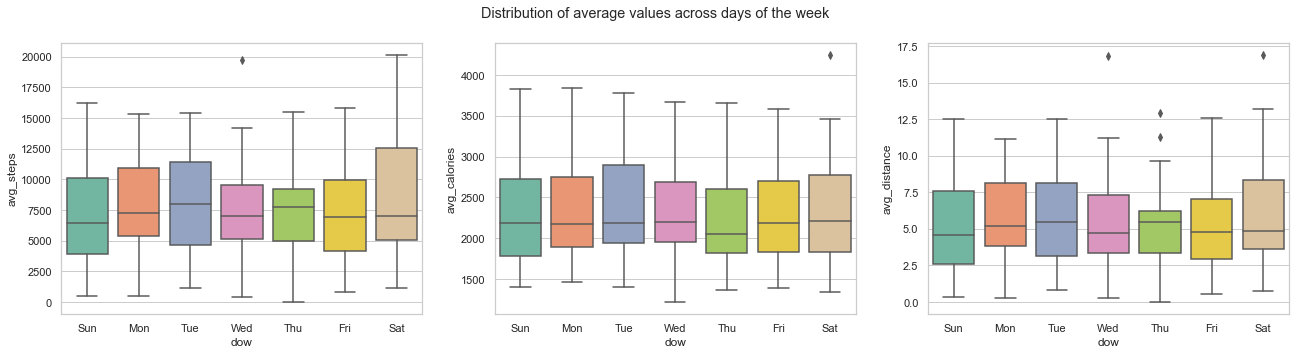

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(22, 5))
fig.suptitle('Distribution of average values across days of the week')

sns.boxplot(x="dow", y="avg_steps", data=activity_dist, ax=axes[0]).set_xticklabels(['Sun','Mon','Tue','Wed','Thu','Fri', 'Sat']);
sns.boxplot(x="dow", y="avg_calories", data=activity_dist, ax=axes[1]).set_xticklabels(['Sun','Mon','Tue','Wed','Thu','Fri', 'Sat']);
sns.boxplot(x="dow", y="avg_distance", data=activity_dist, ax=axes[2]).set_xticklabels(['Sun','Mon','Tue','Wed','Thu','Fri', 'Sat']);

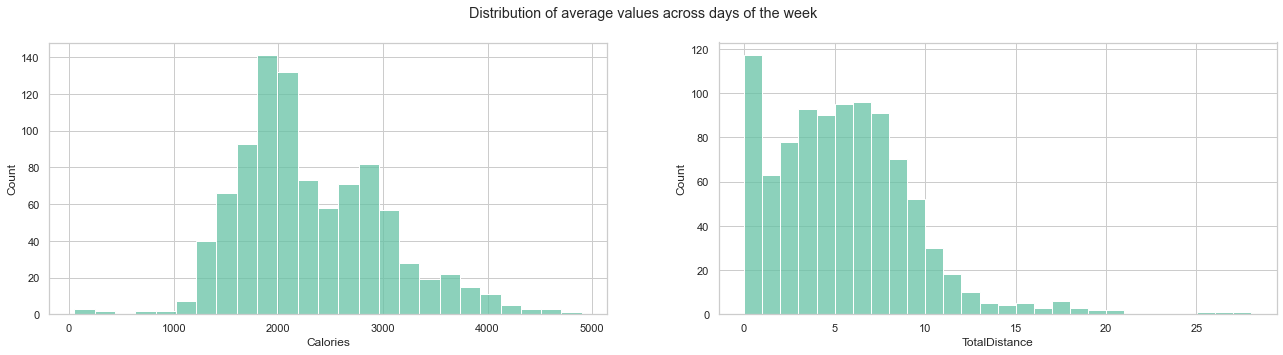

In [29]:
# distribution of calories and distance
fig, axes = plt.subplots(1, 2, figsize=(22, 5))
fig.suptitle('Distribution of average values across days of the week')

sns.histplot(data=full_dailyActivity_df, x="Calories", ax = axes[0]);

sns.histplot(data=full_dailyActivity_df, x="TotalDistance", ax = axes[1]);

How do sedentary minutes change in weekends?

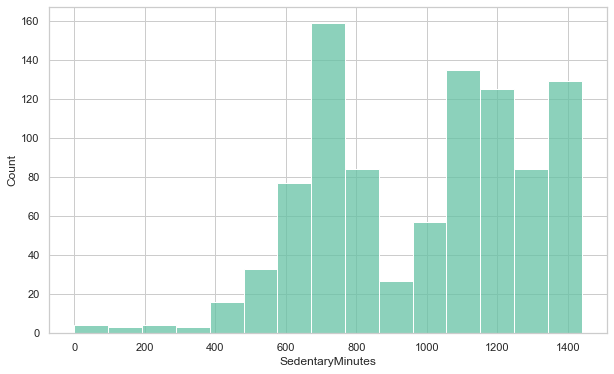

In [30]:
sns.histplot(data= weekend_check, x = 'SedentaryMinutes');

Get a visualization on how this distribution depends on weekends

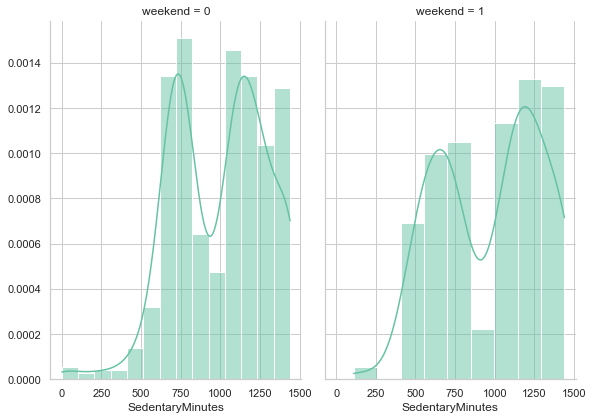

In [31]:
g = sns.FacetGrid(weekend_check, col="weekend", height=6, aspect=.7)
g.map(sns.histplot, "SedentaryMinutes", kde=True, stat='density');

We have now distinguished two groups of users based on the distribution of SedentaryMinutes

In [32]:
query = """
SELECT
	Id,
	AVG(SedentaryMinutes) AS AvgSedentaryMinutes
FROM
	dailyActivity_merged
GROUP BY
	Id
ORDER BY
	AvgSedentaryMinutes DESC;
"""
avg_sed_minutes = pd.read_sql(query, con)

avg_sed_minutes

,Id,AvgSedentaryMinutes
0,1927972279,1317.419355
1,6775888955,1299.423077
2,8253242879,1287.368421
3,8583815059,1267.225806
4,1624580081,1257.741935
5,4020332650,1237.258065
6,2320127002,1220.096774
7,4057192912,1217.250000
8,1844505072,1206.612903
9,6290855005,1193.034483


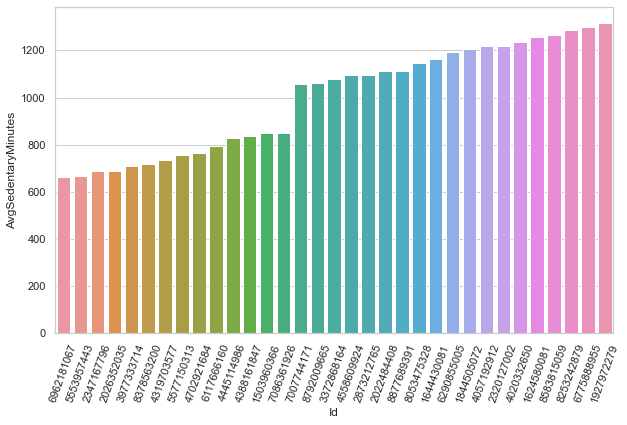

In [33]:
sns.barplot(data = avg_sed_minutes,
            x = 'Id', y = 'AvgSedentaryMinutes',
            order=avg_sed_minutes.sort_values('AvgSedentaryMinutes',ascending = True)['Id'])
plt.xticks(rotation=70);

It seems we may have found a trend here, there is a clear offset which seems to be around the borderline for the two groups. Let's verify that

In [34]:
# get avg sed minutes
cur.execute("SELECT	AVG(SedentaryMinutes) FROM dailyActivity_merged;")
sedMinAvg = cur.fetchall()[0][0]
print(sedMinAvg)

991.2106382978724


We can create a column to identify this user group. We'll call group 1 those with SedentaryMinutes above average and group 0, those bellow.

Rows in group 0 (Less Sedentary group):
416
Rows in group 1 (More Sedentary group):
524
Distinct users in group 0 (Less Sedentary group)
14
Distinct users in group 1 (More Sedentary group)
19


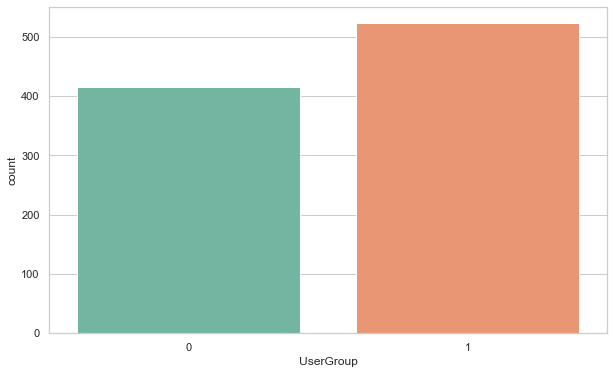

In [35]:
def is_above(user):
    '''Returns 1 if user has average SedentaryMinutes above the total average and 0 otherwise'''
    return int(avg_sed_minutes[avg_sed_minutes['Id']==user]['AvgSedentaryMinutes'].values[0] > sedMinAvg)

weekend_check['UserGroup'] = weekend_check['Id'].apply(is_above)

print(f'Rows in group 0 (Less Sedentary group):')
print(len(weekend_check[weekend_check['UserGroup']==0]))
print(f'Rows in group 1 (More Sedentary group):')
print(len(weekend_check[weekend_check['UserGroup']==1]))

print('Distinct users in group 0 (Less Sedentary group)')
print(weekend_check[weekend_check['UserGroup']==0]['Id'].nunique())

print('Distinct users in group 1 (More Sedentary group)')
print(weekend_check[weekend_check['UserGroup']==1]['Id'].nunique())

sns.countplot(data=weekend_check, x = 'UserGroup');

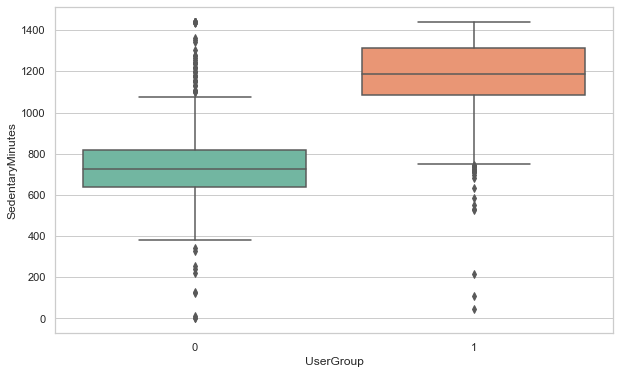

In [36]:
sns.boxplot(x="UserGroup", y="SedentaryMinutes", data=weekend_check);

What are the sleeping habits for each user group?

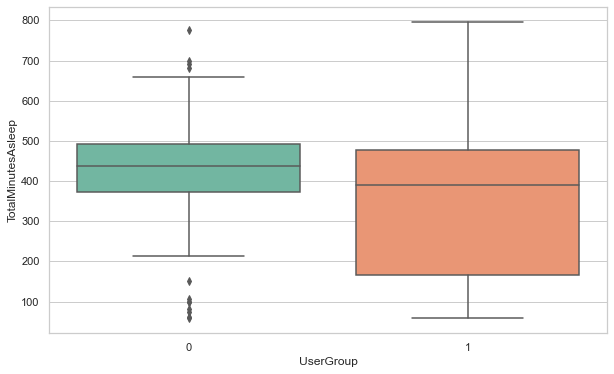

In [37]:
sleep_df['UserGroup'] = sleep_df['Id'].apply(is_above)

sns.boxplot(x="UserGroup", y="TotalMinutesAsleep", data=sleep_df);


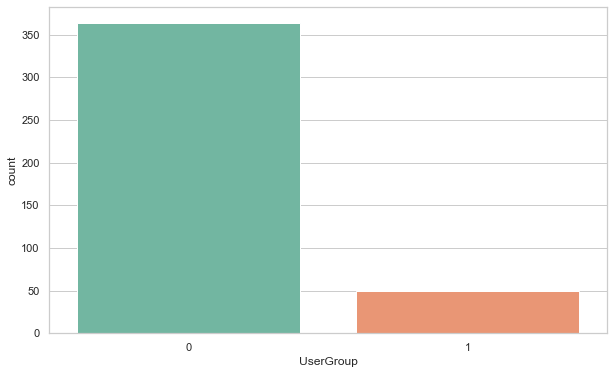

In [38]:
sns.countplot(data = sleep_df, x = 'UserGroup');

In [39]:
sleep_df['UserGroup'].value_counts()

0    364
1     49
Name: UserGroup, dtype: int64

In [40]:
print('Distinct users in group 0 (Less Sedentary group)')
print(sleep_df[sleep_df['UserGroup']==0]['Id'].nunique())

print('Distinct users in group 1 (More Sedentary group)')
print(sleep_df[sleep_df['UserGroup']==1]['Id'].nunique())

Distinct users in group 0 (Less Sedentary group)
14
Distinct users in group 1 (More Sedentary group)
10


<AxesSubplot:xlabel='TotalMinutesAsleep', ylabel='SedentaryMinutes'>

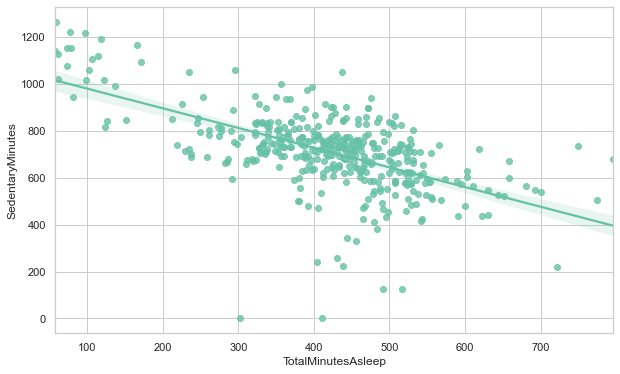

In [41]:
# Join activity and sleep data
join_query = """
SELECT 
	A.Id,
	A.ActivityDate,
	A.SedentaryMinutes,
	S.TotalMinutesAsleep
FROM 
	dailyActivity_merged A
INNER JOIN sleepDay_merged S
ON 
	A.Id = S.Id AND
    A.ActivityDate = S.SleepDay;
"""
activity_sleep_df = pd.read_sql(join_query, con)

sns.regplot(data = activity_sleep_df,
                x = 'TotalMinutesAsleep',
                y = 'SedentaryMinutes')

This is an interesting graph and it makes sense.

Herein, a clear tendency was found as users with more minutes asleep tend to be less sedentary. This is indicative that users who sleep the most, tend to also be more active during the day.

### Part 5: DATA INSIGHTS ###

Using only the daily activity from our 33 users we reached some interesting conclusions! 

Herein, I include some high-level insights derived from the above exploratory analysis:

There is no clear distinction in user activity across different days of the week;
The average number of steps taken daily is around 7670. 

According to some research from the CDC:

...higher daily step counts were associated with lower mortality risk from all causes.

The CDC also informs us that:

...compared with taking 4,000 steps per day, a number considered to be low for adults, taking 8,000 steps per day was associated with a 51% lower risk for all-cause mortality (or death from all causes). Taking 12,000 steps per day was associated with a 65% lower risk compared with taking 4,000 steps.

If the goal is to burn some calories, it was found that there is a linear relation between steps taken and calories burned. Accordingly, we could use user data to fit a model and predict how many steps a user should take in order to reach a certain amount of calories burned. 

Regarding sleeping habits, there was a clear decrease of sedentary minutes as the number of minutes asleep increased. 

So, another goal could be to motivate users to keep a consistent and sufficient sleeping schedule. 

Going back to the CDC:
...being physically active has many benefits, including reducing a person’s risk of obesity, heart disease, type 2 diabetes, and some cancers. And on a daily basis, it can help people feel better and sleep better.

### PART 6: MACHINE LEARNING ###
Based on the above exploratory analysis, it was found that steps taken and calories are somewhat linearly correlated and together they may be indicative of a lower risk for all-cause mortality.

More interestingly, among our data there is one dataset which has not been used yet which is a weight and BMI log.

In [42]:
# check for sample data and data size
weightLogInfo_df = pd.read_sql(f'SELECT * FROM weightLogInfo_merged', con)
print(len(weightLogInfo_df))
weightLogInfo_df.head()

67


,Id,Date,WeightKg,WeightPounds,Fat,BMI,IsManualReport,LogId
0,1503960366,5/2/2016 11:59:59 PM,52.599998,115.963147,22.0,22.650000,1,1462233599000
1,1503960366,5/3/2016 11:59:59 PM,52.599998,115.963147,NaN,22.650000,1,1462319999000
2,1927972279,4/13/2016 1:08:52 AM,133.500000,294.317120,NaN,47.540001,0,1460509732000
3,2873212765,4/21/2016 11:59:59 PM,56.700001,125.002104,NaN,21.450001,1,1461283199000
4,2873212765,5/12/2016 11:59:59 PM,57.299999,126.324875,NaN,21.690001,1,1463097599000


These data have a distinct nature since they are not necessarily machine generated, thereafter they serve the purpose of being 'labels'. In simple words, users are collecting data regarding their activity using their fitbit, and once in a while, they log some body information such as weight, fat and BMI. 

This creates an optimal scenario for a supervised learning problem, where, for example, we could use the fitbit activity data to predict the BMI of a user. Such a prediction could then be used to assess the healthiness of a user.
Moreover, it would even more useful to have access to some other personal information which could be very relevant for the above supervised learning problem, such as height, age and sex.

However, for the purpose of this exercise, the data length of the weightLogInfo_merged dataframe is not sufficient for training an AI model and we do not dispose of personal information of users.

Accordingly, we will then reduce the problem to calories prediction, whereas calories are used as the main variable for assessing the healthiness of a user.

In [43]:
join_query = """
SELECT 
	A.Id,
	A.ActivityDate,
	A.SedentaryMinutes,
    A.Calories,
    A.TotalSteps,
	S.TotalMinutesAsleep,
    S.TotalTimeInBed
FROM 
	dailyActivity_merged A
INNER JOIN sleepDay_merged S
ON 
	A.Id = S.Id AND
    A.ActivityDate = S.SleepDay;
"""

fitbit_df = pd.read_sql(join_query, con)

print(len(fitbit_df))

413


In [44]:
fitbit_df[fitbit_df.isna()].count()

Id                    0
ActivityDate          0
SedentaryMinutes      0
Calories              0
TotalSteps            0
TotalMinutesAsleep    0
TotalTimeInBed        0
dtype: int64

In [45]:
# drop activity date because this is not a time series analysis
# drop id since it is not relevant
fitbit_df = fitbit_df.drop(columns=['Id', 'ActivityDate'])

# The resulting combined dataframe looks like this
fitbit_df.head()

,SedentaryMinutes,Calories,TotalSteps,TotalMinutesAsleep,TotalTimeInBed
0,728,1985,13162,327,346
1,776,1797,10735,384,407
2,726,1745,9762,412,442
3,773,1863,12669,340,367
4,539,1728,9705,700,712


Index(['SedentaryMinutes', 'TotalSteps', 'TotalMinutesAsleep',
       'TotalTimeInBed', 'Calories'],
      dtype='object')


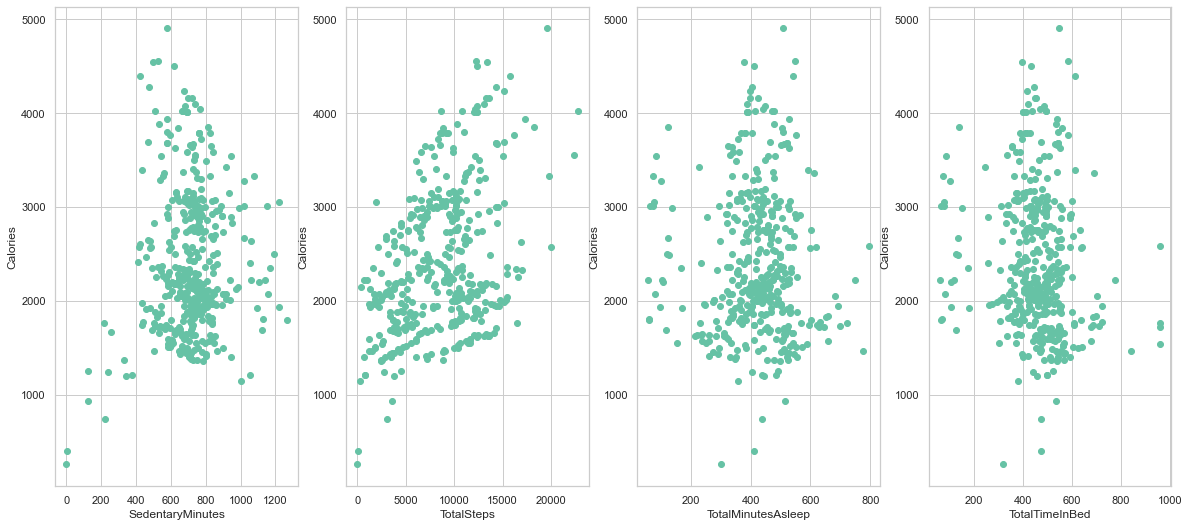

In [46]:
column_to_move = fitbit_df.pop("Calories")
fitbit_df.insert(4, "Calories", column_to_move)
print(fitbit_df.columns)

# Define a function to plot the scatterplots of the relationships between 
# all independent variables and the dependent variable
def plot_relationships(df, num_cols):
    variables = df.columns
    
    # assume that the dependent variable is in the last column
    dep_var = variables[-1]
    ind_var = variables[:-1]
    figs = len(dep_var)
    num_cols = num_cols
    num_rows = round(figs / num_cols) + 1
    fig = 1
    plt.figure(figsize=(20,30))
    # Loop through all independent variables and create the scatter plot
    for i in ind_var:
        pltfignums = [str(num_rows), str(num_cols), str(fig)]
        pltfig = int(''.join(pltfignums))
        plt.subplot(pltfig)
        plt.scatter(df[i], df[dep_var])
        plt.xlabel(str(i))
        plt.ylabel(str(dep_var))
        fig +=1

plot_relationships(fitbit_df,4)

<AxesSubplot:>

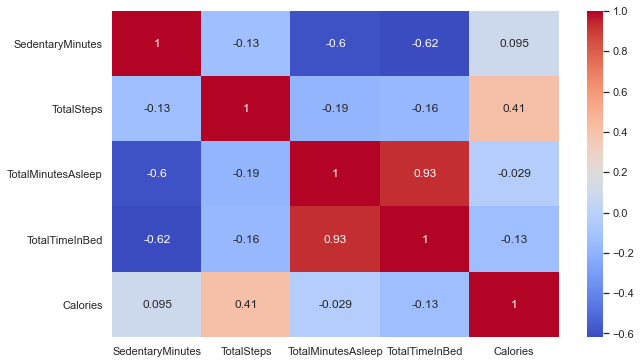

In [47]:
# Plot the correlations as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(fitbit_df.corr(), annot=True, cmap='coolwarm', fmt='.2g')

I want to split the data in a way that the training set is made up of 60% of the total data set and the validation and test set are both made up of 20%. This code achieves the correct percentage splits

In [48]:
from sklearn.model_selection import train_test_split

X_train_temp, X_test, y_train_temp, y_test = train_test_split(fitbit_df.iloc[:,:-1], 
                                                              fitbit_df['Calories'], 
                                                              test_size=0.2, 
                                                              random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_temp, y_train_temp, 
                                                      test_size=0.25, random_state=42)

In [49]:
# scale the data with object range of 0-1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit_transform(X_train)

scaler.transform(X_valid)
scaler.transform(X_test)

array([[0.63330599, 0.36764383, 0.40785908, 0.37555556],
       [0.59557014, 0.45576408, 0.57859079, 0.48777778],
       [0.6997539 , 0.0528282 , 0.5799458 , 0.49111111],
       [0.56193601, 0.54379642, 0.44715447, 0.38444444],
       [0.90730107, 0.20476421, 0.06504065, 0.05222222],
       [0.61443806, 0.31455193, 0.38617886, 0.33222222],
       [0.39294504, 0.42082363, 0.73441734, 0.63888889],
       [0.59639048, 0.49997802, 0.49186992, 0.44      ],
       [0.54060705, 0.47061926, 0.49728997, 0.41555556],
       [0.6923708 , 0.60326111, 0.09214092, 0.08444444],
       [0.3388023 , 0.35990858, 0.57181572, 0.53888889],
       [0.5561936 , 0.36171054, 0.59891599, 0.55111111],
       [0.62674323, 0.23829825, 0.47425474, 0.43222222],
       [0.58736669, 0.30769569, 0.61382114, 0.53555556],
       [0.47087777, 0.40047466, 0.63821138, 0.55222222],
       [0.73420837, 0.08996616, 0.44715447, 0.40333333],
       [0.43478261, 0.28774228, 0.6504065 , 0.55444444],
       [0.47497949, 0.8581286 ,

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def scoring(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mae = mean_absolute_error(test_labels, predictions)
    mse = mean_squared_error(test_labels, predictions)
    r2 = r2_score(test_labels, predictions)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Mean Absolute Error: {:0.4f}.'.format(mae))
    print('Mean Squared Error: {:0.4f}.'.format(mse))
    print('R^2 Score = {:0.4f}.'.format(r2))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
# Create list of median predictions that has the same length as y_valid
baseline_y = [y_train.median()] * len(y_valid)

# Compute the relevant scores
base_predictions = baseline_y
base_mae = mean_absolute_error(y_valid, base_predictions)
base_mse = mean_squared_error(y_valid, base_predictions)
base_r2 = r2_score(y_valid, base_predictions)
base_errors = abs(base_predictions - y_valid)
base_mape = 100 * np.mean(base_errors / y_valid)
base_accuracy = 100 - base_mape
print('Model Performance')
print('Mean Absolute Error: {:0.4f}.'.format(base_mae))
print('Mean Squared Error: {:0.4f}.'.format(base_mse))
print('R^2 Score = {:0.4f}.'.format(base_r2))
print('Accuracy = {:0.2f}%.'.format(base_accuracy))

Model Performance
Mean Absolute Error: 649.0120.
Mean Squared Error: 650005.8072.
R^2 Score = -0.0292.
Accuracy = 72.74%.


We want to establish baseline scores based on the performance of a model which predicts the mean everytime. The baseline is useful to assess whether the models we are going to train are actually 'learning' anything from the data.

Text(0, 0.5, 'Coefficients')

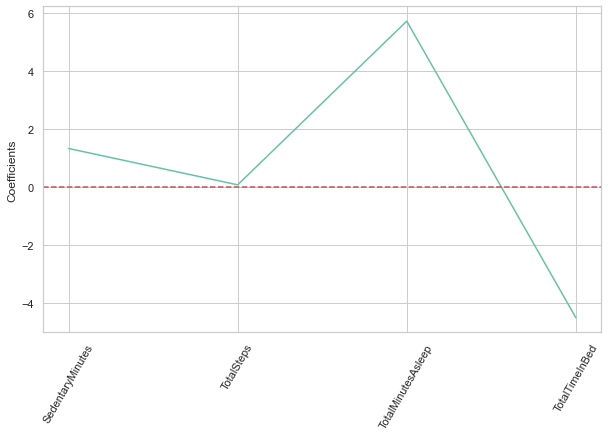

In [51]:
# feature selection with lasso Regression
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_

plt.figure(figsize=(10, 6))
plt.plot(range(len(X_train.columns)), lasso_coef)
plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=60)
plt.axhline(0.0, linestyle='--', color='r')
plt.ylabel('Coefficients')

The Lasso Regression algorithm indicates we may not face any major multicollinearity issue by including all of the features in our models. 

### PART 6A: MULTIPLE LINEAR REGRESSION ####

In [52]:
regressor = LinearRegression()
mlr = regressor.fit(X_train, y_train)

scoring(mlr, X_valid, y_valid)

Model Performance
Mean Absolute Error: 571.5923.
Mean Squared Error: 461353.1211.
R^2 Score = 0.2695.
Accuracy = 74.79%.


### PART 6B: RANDOM FOREST REGRESSOR ####

In [53]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(random_state=42)
rf = rf_regressor.fit(X_train, y_train)

scoring(rf, X_valid, y_valid)

Model Performance
Mean Absolute Error: 506.9816.
Mean Squared Error: 407747.2590.
R^2 Score = 0.3544.
Accuracy = 77.49%.


### PART 6C: EXTREME GRADIENT BOOSTING ###

In [54]:
from xgboost import XGBRegressor
xgb_regressor = XGBRegressor(random_state=42)
xgb = xgb_regressor.fit(X_train, y_train)

scoring(xgb, X_valid, y_valid)

Model Performance
Mean Absolute Error: 499.4119.
Mean Squared Error: 419972.2894.
R^2 Score = 0.3350.
Accuracy = 78.23%.


We have used three different models and all of them (luckily) seem to outperform the baseline, hence the results are meaningful.

### PART 7: CROSS-VALIDATION AND PARAMETERS HYPERTUNING ###

In [55]:
from sklearn.model_selection import cross_val_score

# Define a function that compares the CV perfromance of a set of predetrmined models 
def cv_comparison(models, X, y, cv):
    cv_accuracies = pd.DataFrame()
    maes = []
    mses = []
    r2s = []
    accs = []
    
    # Loop through the models, run a CV, add the average scores to the DataFrame and the scores of all CVs to the list
    for model in models:
        mae = -np.round(cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv), 4)
        maes.append(mae)
        mae_avg = round(mae.mean(), 4)
        mse = -np.round(cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv), 4)
        mses.append(mse)
        mse_avg = round(mse.mean(), 4)
        r2 = np.round(cross_val_score(model, X, y, scoring='r2', cv=cv), 4)
        r2s.append(r2)
        r2_avg = round(r2.mean(), 4)
        acc = np.round((100 - (100 * (mae * len(X))) / sum(y)), 4)
        accs.append(acc)
        acc_avg = round(acc.mean(), 4)
        cv_accuracies[str(model)] = [mae_avg, mse_avg, r2_avg, acc_avg]
    cv_accuracies.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return cv_accuracies, maes, mses, r2s, accs

In [56]:
# Create the models to be tested
mlr_reg = LinearRegression()
rf_reg = RandomForestRegressor(random_state=42)
xgb_reg = xgb_regressor = XGBRegressor(random_state=42)

models = [mlr_reg, rf_reg, xgb_reg]

# Run the Cross-Validation comparison with the models used in this analysis
comp, maes, mses, r2s, accs = cv_comparison(models, X_train_temp, y_train_temp, 4)

comp

,LinearRegression(),RandomForestRegressor(random_state=42),"XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n random_state=42, reg_alpha=None, reg_lambda=None,\n scale_pos_weight=None, subsample=None, tree_method=None,\n validate_parameters=None, verbosity=None)"
Mean Absolute Error,523.9734,471.8517,482.7019
Mean Squared Error,410459.2050,371613.2164,406833.3769
R^2,0.2813,0.3468,0.2825
Accuracy,78.3106,80.4681,80.0190


In [57]:
r2_comp = pd.DataFrame(r2s, index=comp.columns, columns=['1st Fold', '2nd Fold', '3rd Fold', 
                                                         '4th Fold'])

r2_comp['Average'] = np.round(r2_comp.mean(axis=1),4)

r2_comp

,1st Fold,2nd Fold,3rd Fold,4th Fold,Average
LinearRegression(),0.2437,0.2679,0.3072,0.3063,0.2813
RandomForestRegressor(random_state=42),0.4913,0.2705,0.2859,0.3394,0.3468
"XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n random_state=42, reg_alpha=None, reg_lambda=None,\n scale_pos_weight=None, subsample=None, tree_method=None,\n validate_parameters=None, verbosity=None)",0.5418,0.2564,0.1969,0.1348,0.2825


In [58]:
# Set hyperparameters possibilities for tuning Random Forest
rf_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
rf_max_depth = [int(x) for x in np.linspace(5, 55, 11)]
rf_max_depth.append(None)
rf_max_features = ['auto', 'sqrt', 'log2']
rf_criterion = ['mse', 'mae']
rf_min_samples_split = [int(x) for x in np.linspace(2, 10, 9)]
rf_min_impurity_decrease = [0.0, 0.05, 0.1]
rf_bootstrap = [True, False]

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_split': rf_min_samples_split,
               'min_impurity_decrease': rf_min_impurity_decrease,
               'bootstrap': rf_bootstrap}

rf_grid

{'n_estimators': [200, 400, 600, 800, 1000],
 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'criterion': ['mse', 'mae'],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_impurity_decrease': [0.0, 0.05, 0.1],
 'bootstrap': [True, False]}

In [59]:
from sklearn.model_selection import RandomizedSearchCV

# Tune the Random Forest Model
rf_base = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid, 
                               n_iter = 200, cv = 3, verbose = 2, random_state = 42, 
                               n_jobs = -1)

rf_random.fit(X_train_temp, y_train_temp)

rf_random.best_estimator_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  3.8min finished


RandomForestRegressor(criterion='mae', max_depth=35, min_impurity_decrease=0.1,
                      min_samples_split=5, n_estimators=200)

In [60]:
# Set hyperparameters possibilities for tuning XGBoost
xgb_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
xgb_max_depth = [int(x) for x in np.linspace(2, 20, 10)]
xgb_min_child_weight = [int(x) for x in np.linspace(1, 10, 10)]
xgb_tree_method = ['auto', 'exact', 'approx', 'hist', 'gpu_hist']
xgb_eta = [x for x in np.linspace(0.1, 0.6, 6)]
xgb_gamma = [int(x) for x in np.linspace(0, 0.5, 6)]
xgb_objective = ['reg:squarederror', 'reg:squaredlogerror']

# Create the grid
xgb_grid = {'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'min_child_weight': xgb_min_child_weight,
            'tree_method': xgb_tree_method,
            'eta': xgb_eta,
            'gamma': xgb_gamma,
            'objective': xgb_objective}

In [61]:
# Tune the XGBoost Model
xgb_base = XGBRegressor()

xgb_random = RandomizedSearchCV(estimator = xgb_base, param_distributions = xgb_grid, 
                                n_iter = 200, cv = 3, verbose = 2, 
                                random_state = 42, n_jobs = -1)

xgb_random.fit(X_train_temp, y_train_temp)

xgb_random.best_params_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.7min finished


{'tree_method': 'approx',
 'objective': 'reg:squarederror',
 'n_estimators': 1000,
 'min_child_weight': 2,
 'max_depth': 18,
 'gamma': 0,
 'eta': 0.30000000000000004}

### PART 8: FINAL MODEL EVALUATION ###

In [62]:
# Create the final Multiple Linear Regression
mlr_final = LinearRegression()

# Create the final Random Forest
rf_final = RandomForestRegressor(n_estimators = 600,
                                 min_samples_split = 4,
                                 min_impurity_decrease = 0.05,
                                 max_features = 'sqrt',
                                 max_depth = 15,
                                 criterion = 'mae',
                                 bootstrap = True,
                                 random_state = 42)

# Create the fnal Extreme Gradient Booster
xgb_final = XGBRegressor(tree_method = 'approx',
                         objective = 'reg:squarederror',
                         n_estimators = 80,
                         min_child_weight = 4,
                         max_depth = 12,
                         gamma = 0,
                         eta = 0.1,
                         random_state = 42)

# Train the models using 80% of the original data
mlr_final.fit(X_train_temp, y_train_temp)
rf_final.fit(X_train_temp, y_train_temp)
xgb_final.fit(X_train_temp, y_train_temp)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=12,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=80, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=None)

In [63]:
# Define a function that compares all final models
def final_comparison(models, test_features, test_labels):
    scores = pd.DataFrame()
    for model in models:
        predictions = model.predict(test_features)
        mae = round(mean_absolute_error(test_labels, predictions), 4)
        mse = round(mean_squared_error(test_labels, predictions), 4)
        r2 = round(r2_score(test_labels, predictions), 4)
        errors = abs(predictions - test_labels)
        mape = 100 * np.mean(errors / test_labels)
        accuracy = round(100 - mape, 4)
        scores[str(model)] = [mae, mse, r2, accuracy]
    scores.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return scores

In [64]:
# Run the Cross-Validation comparison with the models used in this analysis
comp, maes, mses, r2s, accs = cv_comparison(models, X_train_temp, y_train_temp, 4)

comp

,LinearRegression(),RandomForestRegressor(random_state=42),"XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n random_state=42, reg_alpha=None, reg_lambda=None,\n scale_pos_weight=None, subsample=None, tree_method=None,\n validate_parameters=None, verbosity=None)"
Mean Absolute Error,523.9734,471.8517,482.7019
Mean Squared Error,410459.2050,371613.2164,406833.3769
R^2,0.2813,0.3468,0.2825
Accuracy,78.3106,80.4681,80.0190


The cross-validation and hyper parameters fine-tuning has contributed to improve accuracy. 

The performance of the models can probably be improved by choosing smaller intervals of estimators over a larger span. Overall, the random forest seemed to give the best results with a 80.5% accuracy.

### PART 9: IMPLEMENT BEST PERFORMING MODEL INTO A BIG DATA APPROACH ###
Assuming our dataset may be more extended, we implement a more scalable application of the above prototype for the best performing model only.

For a matter of simplicity, we will directly use the dataframe previously created in Pandas.

In [65]:
fitbit_df.to_csv('fitbit_df.csv', index=False)

CSV_PATH = "./fitbit_df.csv"
APP_NAME = "Random Forest"
SPARK_URL = "local[*]"
RANDOM_SEED = 13579
TRAINING_DATA_RATIO = 0.7
RF_NUM_TREES = 3
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32

from pyspark import SparkContext
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName(APP_NAME) \
    .master(SPARK_URL) \
    .getOrCreate()

df = spark.read \
    .options(header = "true", inferschema = "true") \
    .csv(CSV_PATH)

print("Total number of rows: %d" % df.count())

df.printSchema()

df.show()

Total number of rows: 413
root
 |-- SedentaryMinutes: integer (nullable = true)
 |-- TotalSteps: integer (nullable = true)
 |-- TotalMinutesAsleep: integer (nullable = true)
 |-- TotalTimeInBed: integer (nullable = true)
 |-- Calories: integer (nullable = true)

+----------------+----------+------------------+--------------+--------+
|SedentaryMinutes|TotalSteps|TotalMinutesAsleep|TotalTimeInBed|Calories|
+----------------+----------+------------------+--------------+--------+
|             728|     13162|               327|           346|    1985|
|             776|     10735|               384|           407|    1797|
|             726|      9762|               412|           442|    1745|
|             773|     12669|               340|           367|    1863|
|             539|      9705|               700|           712|    1728|
|             775|     15506|               304|           320|    2035|
|             818|     10544|               360|           377|    1786|
|      

In [66]:
# create features
from pyspark.ml.feature import VectorAssembler

featureCols = ['SedentaryMinutes', 'TotalSteps', 'TotalMinutesAsleep',
       'TotalTimeInBed']
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
df = assembler.transform(df)
spark_df = df.select(['features', 'Calories'])

spark_df.show()
spark_df.printSchema()


+--------------------+--------+
|            features|Calories|
+--------------------+--------+
|[728.0,13162.0,32...|    1985|
|[776.0,10735.0,38...|    1797|
|[726.0,9762.0,412...|    1745|
|[773.0,12669.0,34...|    1863|
|[539.0,9705.0,700...|    1728|
|[775.0,15506.0,30...|    2035|
|[818.0,10544.0,36...|    1786|
|[838.0,9819.0,325...|    1775|
|[732.0,14371.0,36...|    1949|
|[709.0,10039.0,43...|    1788|
|[814.0,15355.0,27...|    2013|
|[833.0,13755.0,24...|    1970|
|[782.0,13154.0,36...|    1898|
|[815.0,11181.0,34...|    1837|
|[712.0,14673.0,40...|    1947|
|[730.0,10602.0,36...|    1820|
|[798.0,14727.0,27...|    2004|
|[816.0,15103.0,27...|    1990|
|[857.0,14070.0,24...|    1959|
|[754.0,12159.0,33...|    1896|
+--------------------+--------+
only showing top 20 rows

root
 |-- features: vector (nullable = true)
 |-- Calories: integer (nullable = true)



In [67]:
train, test = spark_df.randomSplit([0.8, 0.2], seed = 42)
print("Number of training set rows: %d" % train.count())
print("Number of test set rows: %d" % test.count())

Number of training set rows: 354
Number of test set rows: 59


In [71]:
import pyspark
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(featuresCol="features", labelCol='Calories')

model = rf.fit(train)

predictions = model.transform(test)

predictions.select("prediction", "Calories", "features").show(5)

preds = predictions.select('prediction').toPandas()['prediction']
test_labels = predictions.select('Calories').toPandas()['Calories']

errors = abs(preds - test_labels)
mape = 100 * np.mean(errors / test_labels)
accuracy = round(100 - mape, 4)
print(f'Accuracy = {accuracy} %')


+-----------------+--------+--------------------+
|       prediction|Calories|            features|
+-----------------+--------+--------------------+
|1795.464506034107|    1248|[125.0,4477.0,492...|
|961.4281944444444|    1240|[241.0,2752.0,404...|
|2447.758699977484|    1364|[330.0,8891.0,456...|
|2744.346742205146|    2606|[425.0,11135.0,46...|
|2408.031228536025|    2469|[456.0,7336.0,498...|
+-----------------+--------+--------------------+
only showing top 5 rows

Accuracy = 76.9672 %


An (almost) identical result has been obtained in a Spark environment, whereas the accuracy of the previous Random Forest Model before hyperparameters tuning was 77.5% and now 77% was obtained.